In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import heapq
from collections import defaultdict

In [2]:
class ISISRouter:
    def __init__(self, router_id, level=1):
        self.router_id = router_id
        self.level = level
        self.link_state_db = {}
        self.neighbors = {}
        self.routing_table = {}
        self.sequence_number = 0
    
    def add_neighbor(self, neighbor_id, cost):
        self.neighbors[neighbor_id] = cost
    
    def generate_lsp(self):
        self.sequence_number += 1
        return {
            'router_id': self.router_id,
            'sequence': self.sequence_number,
            'neighbors': self.neighbors.copy()
        }
    
    def process_lsp(self, lsp):
        router_id = lsp['router_id']
        sequence = lsp['sequence']
        neighbors = lsp['neighbors']
        
        if router_id not in self.link_state_db:
            self.link_state_db[router_id] = {'sequence': sequence, 'neighbors': neighbors}
            return True
        else:
            if sequence > self.link_state_db[router_id]['sequence']:
                self.link_state_db[router_id] = {'sequence': sequence, 'neighbors': neighbors}
                return True
        
        return False
    
    def compute_spf(self):
        all_routers = set([self.router_id])
        for router_id, data in self.link_state_db.items():
            all_routers.add(router_id)
            for neighbor in data['neighbors'].keys():
                all_routers.add(neighbor)
        
        distances = {router: float('inf') for router in all_routers}
        distances[self.router_id] = 0
        next_hops = {}
        visited = set()
        pq = [(0, self.router_id, self.router_id)]
        
        while pq:
            current_dist, current_router, first_hop = heapq.heappop(pq)
            
            if current_router in visited:
                continue
            
            visited.add(current_router)
            
            if current_router != self.router_id:
                next_hops[current_router] = first_hop
            
            neighbors = {}
            if current_router == self.router_id:
                neighbors = self.neighbors
            elif current_router in self.link_state_db:
                neighbors = self.link_state_db[current_router]['neighbors']
            
            for neighbor, cost in neighbors.items():
                if neighbor not in visited:
                    new_dist = current_dist + cost
                    
                    if new_dist < distances[neighbor]:
                        distances[neighbor] = new_dist
                        new_first_hop = first_hop if current_router != self.router_id else neighbor
                        heapq.heappush(pq, (new_dist, neighbor, new_first_hop))
        
        self.routing_table = {}
        for dest, dist in distances.items():
            if dest != self.router_id and dist != float('inf'):
                self.routing_table[dest] = (dist, next_hops.get(dest, dest))
    
    def display_lsdb(self):
        print(f"\nLink State Database for Router {self.router_id}:")
        print("-" * 60)
        print(f"{'Router ID':<15} {'Sequence':<12} {'Neighbors':<30}")
        print("-" * 60)
        print(f"{self.router_id:<15} {self.sequence_number:<12} {str(self.neighbors):<30}")
        for router_id in sorted(self.link_state_db.keys()):
            data = self.link_state_db[router_id]
            print(f"{router_id:<15} {data['sequence']:<12} {str(data['neighbors']):<30}")
        print("-" * 60)
    
    def display_routing_table(self):
        print(f"\nRouting Table for Router {self.router_id} (Level {self.level}):")
        print("-" * 50)
        print(f"{'Destination':<15} {'Cost':<10} {'Next Hop':<15}")
        print("-" * 50)
        for dest in sorted(self.routing_table.keys()):
            cost, next_hop = self.routing_table[dest]
            print(f"{dest:<15} {cost:<10} {next_hop:<15}")
        print("-" * 50)

In [3]:
def simulate_isis(topology, level=1):
    routers = {}
    
    for router_id in topology.keys():
        routers[router_id] = ISISRouter(router_id, level)
    
    for router_id, neighbors in topology.items():
        for neighbor_id, cost in neighbors.items():
            routers[router_id].add_neighbor(neighbor_id, cost)
    
    print("Starting IS-IS Simulation...")
    print("=" * 70)
    print(f"Running IS-IS Level {level}")
    print("=" * 70)
    
    print("\nPhase 1: LSP Generation")
    print("-" * 70)
    
    lsp_database = {}
    for router_id, router in routers.items():
        lsp = router.generate_lsp()
        lsp_database[router_id] = lsp
        print(f"Router {router_id} generated LSP (Seq: {lsp['sequence']}): {lsp['neighbors']}")
    
    print("\nPhase 2: LSP Flooding")
    print("-" * 70)
    
    max_iterations = 10
    iteration = 0
    
    while iteration < max_iterations:
        iteration += 1
        updated = False
        
        print(f"\n--- Flooding Round {iteration} ---")
        
        for router_id, router in routers.items():
            for other_id, lsp in lsp_database.items():
                if router.process_lsp(lsp):
                    updated = True
                    print(f"Router {router_id} received LSP from Router {other_id}")
        
        if not updated:
            print(f"\nLSDB synchronized after {iteration} rounds!")
            break
    
    print("\nPhase 3: SPF Calculation")
    print("-" * 70)
    
    for router_id, router in routers.items():
        router.compute_spf()
        print(f"Router {router_id} computed SPF")
    
    print("\n" + "=" * 70)
    print("LINK STATE DATABASES")
    print("=" * 70)
    
    for router_id in sorted(routers.keys()):
        routers[router_id].display_lsdb()
    
    print("\n" + "=" * 70)
    print("FINAL ROUTING TABLES")
    print("=" * 70)
    
    for router_id in sorted(routers.keys()):
        routers[router_id].display_routing_table()
    
    return routers

In [4]:
def visualize_topology(topology):
    G = nx.Graph()
    
    for router, neighbors in topology.items():
        for neighbor, cost in neighbors.items():
            G.add_edge(router, neighbor, weight=cost)
    
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(12, 8))
    
    nx.draw_networkx_nodes(G, pos, node_color='lightcoral', 
                          node_size=1500, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=12, font_weight='bold')
    nx.draw_networkx_edges(G, pos, width=2, alpha=0.6)
    
    edge_labels = nx.get_edge_attributes(G, 'weight')
    nx.draw_networkx_edge_labels(G, pos, edge_labels, font_size=10)
    
    plt.title("IS-IS Network Topology", fontsize=16, fontweight='bold')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

In [5]:
def compare_with_ospf():
    print("\n" + "=" * 70)
    print("IS-IS vs OSPF Comparison")
    print("=" * 70)
    
    comparison = [
        ("Protocol Layer", "IS-IS operates at Layer 2 (Data Link)", "OSPF operates at Layer 3 (Network)"),
        ("Addressing", "Uses NSAP addresses", "Uses IP addresses"),
        ("Protocol ID", "Uses CLNP (Connectionless Network Protocol)", "Uses IP protocol 89"),
        ("Hierarchy", "Two-level hierarchy (L1 and L2)", "Area-based hierarchy"),
        ("Convergence", "Slightly faster due to simpler flooding", "Fast convergence"),
        ("Scalability", "Highly scalable, used in large ISP networks", "Scalable with proper area design"),
        ("Packet Overhead", "Lower overhead", "Slightly higher overhead"),
        ("Algorithm", "Dijkstra's SPF algorithm", "Dijkstra's SPF algorithm"),
        ("Deployment", "Common in ISP and carrier networks", "Common in enterprise networks")
    ]
    
    print(f"\n{'Feature':<20} {'IS-IS':<35} {'OSPF':<35}")
    print("-" * 90)
    for feature, isis_val, ospf_val in comparison:
        print(f"{feature:<20} {isis_val:<35} {ospf_val:<35}")
    print("-" * 90)

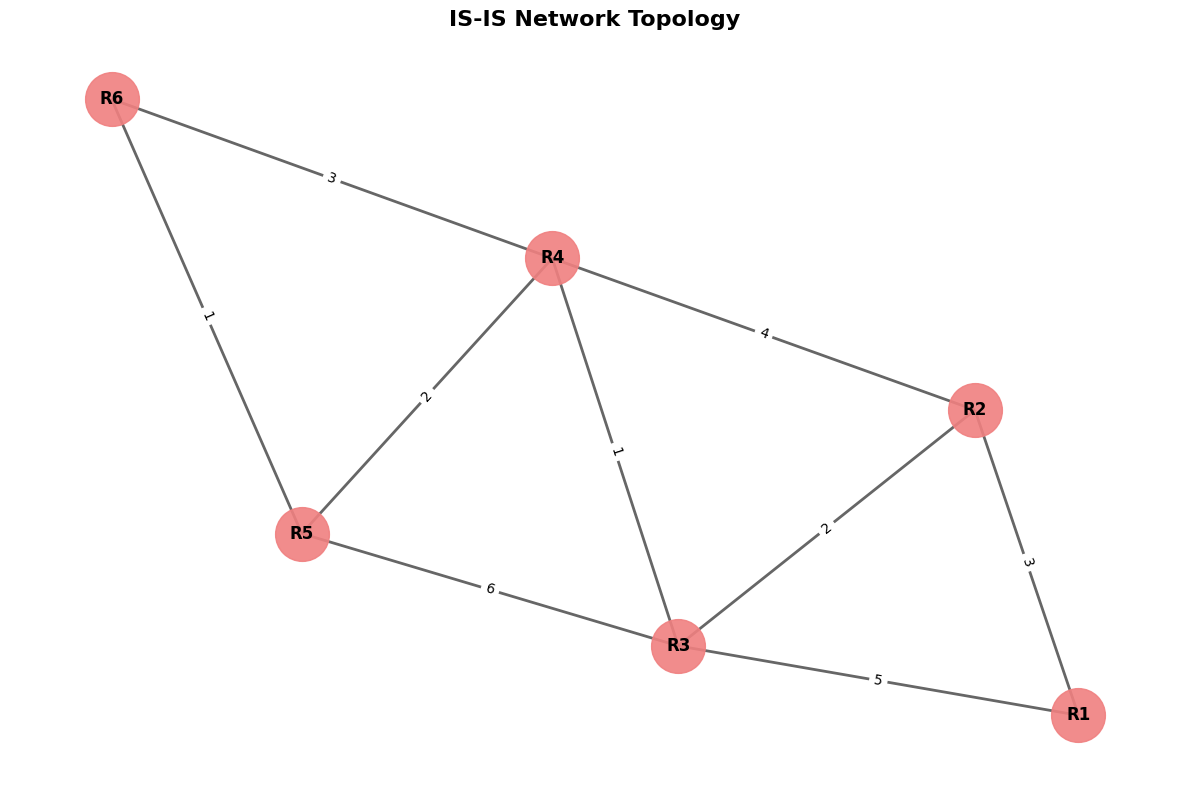

In [6]:
topology = {
    'R1': {'R2': 3, 'R3': 5},
    'R2': {'R1': 3, 'R3': 2, 'R4': 4},
    'R3': {'R1': 5, 'R2': 2, 'R4': 1, 'R5': 6},
    'R4': {'R2': 4, 'R3': 1, 'R5': 2, 'R6': 3},
    'R5': {'R3': 6, 'R4': 2, 'R6': 1},
    'R6': {'R4': 3, 'R5': 1}
}

visualize_topology(topology)

In [7]:
routers = simulate_isis(topology, level=1)

Starting IS-IS Simulation...
Running IS-IS Level 1

Phase 1: LSP Generation
----------------------------------------------------------------------
Router R1 generated LSP (Seq: 1): {'R2': 3, 'R3': 5}
Router R2 generated LSP (Seq: 1): {'R1': 3, 'R3': 2, 'R4': 4}
Router R3 generated LSP (Seq: 1): {'R1': 5, 'R2': 2, 'R4': 1, 'R5': 6}
Router R4 generated LSP (Seq: 1): {'R2': 4, 'R3': 1, 'R5': 2, 'R6': 3}
Router R5 generated LSP (Seq: 1): {'R3': 6, 'R4': 2, 'R6': 1}
Router R6 generated LSP (Seq: 1): {'R4': 3, 'R5': 1}

Phase 2: LSP Flooding
----------------------------------------------------------------------

--- Flooding Round 1 ---
Router R1 received LSP from Router R1
Router R1 received LSP from Router R2
Router R1 received LSP from Router R3
Router R1 received LSP from Router R4
Router R1 received LSP from Router R5
Router R1 received LSP from Router R6
Router R2 received LSP from Router R1
Router R2 received LSP from Router R2
Router R2 received LSP from Router R3
Router R2 received 

In [8]:
compare_with_ospf()


IS-IS vs OSPF Comparison

Feature              IS-IS                               OSPF                               
------------------------------------------------------------------------------------------
Protocol Layer       IS-IS operates at Layer 2 (Data Link) OSPF operates at Layer 3 (Network) 
Addressing           Uses NSAP addresses                 Uses IP addresses                  
Protocol ID          Uses CLNP (Connectionless Network Protocol) Uses IP protocol 89                
Hierarchy            Two-level hierarchy (L1 and L2)     Area-based hierarchy               
Convergence          Slightly faster due to simpler flooding Fast convergence                   
Scalability          Highly scalable, used in large ISP networks Scalable with proper area design   
Packet Overhead      Lower overhead                      Slightly higher overhead           
Algorithm            Dijkstra's SPF algorithm            Dijkstra's SPF algorithm           
Deployment           Co